In [1]:
import pandas as pd
import gzip
import json
from tqdm import tqdm

In [3]:
def get_nth_key(dictionary, n=0):
    if n < 0:
        n += len(dictionary)
    for i, key in enumerate(dictionary.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range")

is_ca = lambda entry: not entry['oa_details'][get_nth_key(entry['oa_details'], -1)]['is_oa']

def is_wiley(entry):
    if is_ca(entry):
        return entry.get("publisher_normalized") == "Wiley"
    else:
        oa_location = entry['oa_details'][get_nth_key(entry['oa_details'], -1)]
        for oa_location in latest_observation['oa_locations']:
            if ('url_for_pdf' in oa_location) and oa_location['url_for_pdf']:
                for i, strategy in enumerate(oa_harvesting_strategy):
                    if strategy(oa_location):
                        update_dict(urls_for_pdf, i, oa_location['url_for_pdf'])
                        update_dict(oa_locations, i, oa_location)

def is_hal(entry):
    oa_location = entry['oa_details'][get_nth_key(entry['oa_details'], -1)]
    return oa_location.get("repository_normalized") == "HAL"

In [4]:
db = pd.read_csv('../../tmp/db_dump_2022-04-25.csv')

In [5]:
ca = []
oa = []
wiley_ca = []
wiley_oa = []
hal = []
with gzip.open('/Users/antoine.bres/dev/BSO/tmp/bso-publications-20220410.jsonl.gz', 'rt') as f:
    for line in tqdm(f.readlines()):
        entry = json.loads(line)
        is_ca_entry = is_ca(entry)
        if is_ca_entry:
            ca.append(entry['doi'])
            if entry.get("publisher_normalized") == "Wiley":
                wiley_ca.append(entry['doi'])
        else:
            oa.append(entry['doi'])
            for oa_location in entry['oa_details'][get_nth_key(entry['oa_details'], -1)]['oa_locations']:
                if oa_location.get("repository_normalized") and oa_location.get("repository_normalized") == "HAL":
                    hal.append(entry['doi'])
                if oa_location.get("url_for_pdf") and 'wiley' in oa_location.get("url_for_pdf"):
                    wiley_oa.append(entry['doi'])

oa = set(oa)
ca = set(ca)
nb_ca = len(ca)
nb_oa = len(oa)
total_nb = nb_ca + nb_oa

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1352492/1352492 [01:32<00:00, 14628.69it/s]


In [6]:
oa_in_db = oa & set(db.doi.to_list())

In [7]:
db['oa'] = db.doi.apply(lambda doi: doi in oa_in_db)

In [8]:
print(f"{total_nb:,} publications in total\n{nb_oa:,} publications in open access ({nb_oa/total_nb:.2%})\n{nb_ca:,} publications in closed access ({nb_ca/total_nb:.2%})")

1,352,428 publications in total
617,140 publications in open access (45.63%)
735,288 publications in closed access (54.37%)


In [9]:
print(f"{len(db):,} publications harvested\n{db.oa.sum():,} OA ({db.oa.sum()/nb_oa:.2%} of {nb_oa:,})\n{len(db) - db.oa.sum():,} CA")

427,544 publications harvested
425,589 OA (68.96% of 617,140)
1,955 CA


In [10]:
hal_in_db = set(db.doi.to_list()) & set(hal)
w_oa_in_db = set(db.doi.to_list()) & set(wiley_oa)
w_ca_in_db = set(db.doi.to_list()) & set(wiley_ca)

In [11]:
print(f"HAL: {len(hal_in_db):,} in db, {len(hal_in_db)/len(set(hal)):.2%} of total ({len(set(hal)):,})")
print(f"Wiley OA: {len(w_oa_in_db):,} in db, {len(w_oa_in_db)/len(set(wiley_oa)):.2%} of total ({len(set(wiley_oa)):,})")
print(f"Wiley CA: {len(w_ca_in_db):,} in db, {len(w_ca_in_db)/len(set(wiley_ca)):.2%} of total ({len(set(wiley_ca)):,})")

HAL: 141,796 in db, 88.92% of total (159,472)
Wiley OA: 13,581 in db, 57.66% of total (23,554)
Wiley CA: 1,955 in db, 3.85% of total (50,782)


In [12]:
df = pd.DataFrame(db.doi)
df['is_harvested'] = True

In [13]:
oa_df = pd.DataFrame(oa, columns=['doi'])
oa_df['is_oa'] = True
ca_df = pd.DataFrame(ca, columns=['doi'])
ca_df['is_oa'] = False
df = oa_df.append(ca_df)
harvested = df.doi.isin(db.doi)
df['is_harvested'] = False
df.loc[harvested, 'is_harvested'] = True

In [14]:
repo_hal = df.doi.isin(hal)
repo_wiley = df.doi.isin(wiley_ca + wiley_oa)
df['repo'] = "NC"
df.loc[repo_hal, 'repo'] = "HAL"
df.loc[repo_wiley, 'repo'] = "Wiley"

In [15]:
agg_df = df.groupby(['is_oa', 'is_harvested', 'repo']).agg('count')
agg_df = agg_df.reset_index()

In [16]:
import seaborn as sns
sns.set_style()

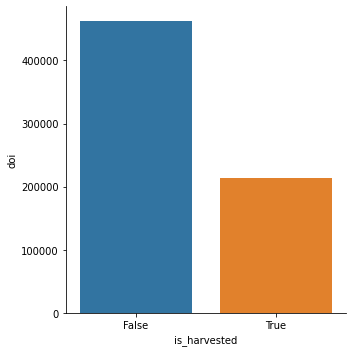

In [17]:
sns.catplot(x="is_harvested", y="doi",
                data=agg_df[['is_oa', 'is_harvested', 'doi']]\
            .groupby(['is_oa', 'is_harvested']).sum().reset_index(),
                kind="bar", ci=None)

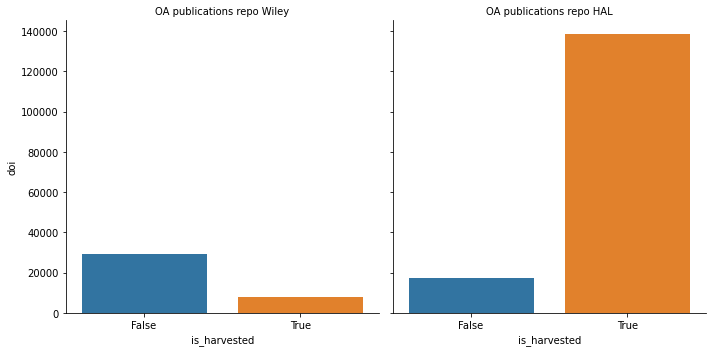

In [18]:
g = sns.catplot(x="is_harvested", y="doi", col="repo",
                data=agg_df.query('repo!="NC"'),
                kind="bar", col_order=['Wiley', 'HAL'],  ci=None)
g.set_titles("OA publications repo {col_name}")

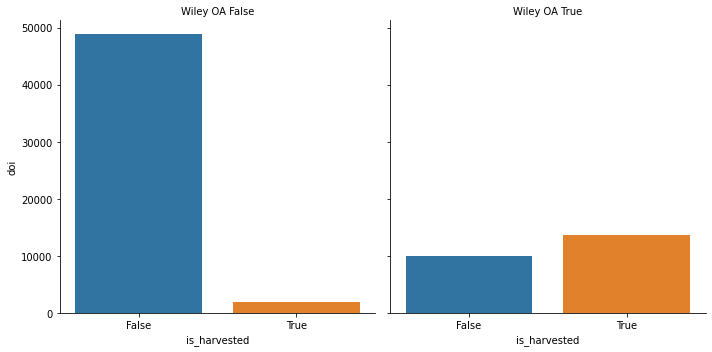

In [19]:
g = sns.catplot(x="is_harvested", y="doi", col="is_oa",
                data=agg_df.query('repo=="Wiley"'),
                kind="bar",  ci=None)
g.set_titles("Wiley OA {col_name}")